## Things to do 
- Handle when we have to find params and plots for each temperature
- Firstly see what is the problem with that graph (why the lines are not coming), check the predict function
- Make the website work according to the modified code
- Include documentation in the code itself
- Tell some internals of the code
- Make the base class more good by asking from gemini

In [1]:
import sys
sys.path.append(r"D:\Study\Python\Projects\Paul Project\Deployment\yup\Probabilistic-model")

from utils import *
from probabilistic_models import *

In [2]:
data_lcf = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\Data-LCF.xlsx")
df_dict = {temp: data_lcf[data_lcf["Temperature"] == temp].reset_index(drop=True) for temp in data_lcf["Temperature"].unique()}
data_lcf['Inverse_Temp'] = 11604.53 / (data_lcf['Temperature'] + 273.16)
data_lcf['Ln_Strain'] = np.log(data_lcf['Strain amplitude'])

## Utils:

In [ ]:
from scipy.optimize import differential_evolution

def minimize(log_likelihood, bounds, args):
    result_regression = differential_evolution(
    log_likelihood,
    args=args,
    bounds=bounds,
)

    return result_regression.x

In [ ]:
def plot_different_cdf_two_var(predict, params,temperature,cdf=[0.5,0.9,0.1,0.99,0.01]):
    fig, ax = plt.subplots(figsize=(8,6))
    
    strain_values = np.linspace(0.002,0.020, 100)
    temperature_values = np.ones_like(strain_values) * temperature
    data = data_lcf[data_lcf['Temperature']==temperature]

    ax.scatter(data["Unnamed: 2"] ,data['Strain amplitude'], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 1")

    for i in range(len(cdf)):
        ys_predicted_cdf = predict(cdf[i],temperature_values, strain_values, params)
        ax.plot( ys_predicted_cdf,strain_values, linestyle="-", linewidth=1, label=f"Predicted YS (CDF={cdf[i]})")

    ax.set_xscale('log')
    ax.set_xlabel("Total Strain Amplitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Normalized Failure Cycle", fontsize=12, fontweight="bold")
    ax.set_title("For Temperature {}".format(temperature), fontsize=14, fontweight="bold")
    ax.set_xlim(1e-3,1)
    ax.legend()
    fig.show()

In [ ]:
def plot_cdf_two_var_diff_temp(model):
    for temp in data_lcf['Temperature'].unique():
        data = data_lcf[data_lcf['Temperature']==temp]
        params = model.minimize(model.bounds, (data['Inverse_Temp'], data['Failure cycle'], data['Ln_Strain']))
        plot_different_cdf_two_var(model.two_var_predict, params, temp)

In [205]:
class ProbModel(ABC):
    @abstractmethod
    def log_likelihood(self):
        pass

    def minimize(self, bounds, args)->np.ndarray:
        result_regression = differential_evolution(
                                self.log_likelihood,
                                bounds=bounds,
                                args=args,
                            )

        return result_regression.x

    @abstractmethod
    def predict(self):
        pass

## Weibull Model:

In [174]:
class WeibullModel(ProbModel):
    def __init__(self,X_values:np.ndarray, Y_values:np.ndarray,X_values2:np.ndarray=np.array([]), power_law:bool=False)->None:
        """Intializes Weibull Probabilistic Model

        Args:
            X_values (np.ndarray): Temperature Values
            Y_values (np.ndarray): Sigma Values
            power_law (bool, optional): Whether to use power law or not. Defaults to False, which means that we will use Arrhenius equation instead of power law. 
        """
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Weibull Model"
        self.tab_name = "Weibull"
        if power_law:
            self.name = "Weibull Model With Power Law"
            self.tab_name = "Weibull (Power)"

        # Figure out the parameters
        self.two_var = False
        if len(X_values2):
            self.init_params = [2.0,-1, np.log(np.mean(self.Y_values)), -3.0]
            self.bounds = [(1e-6, 20), (-20, 20),(-20, 20), (-20, 20)]
            self.name = "Weibull Model With Two variables"
            self.two_var = True

            self.shape, self.intercept, self.slope, self.v = self.minimize( self.bounds, args=(self.X_values, self.Y_values, self.X_values2))
        else:
            init_params = [2.0, np.log(np.mean(self.Y_values)), 0.0]
            bounds = [(1e-6, 20), (-20, 20), (-20, 20)]

            self.power_law = power_law
            self.shape, self.intercept, self.slope = self.minimize( bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self,params:list, temp:np.ndarray, sigma_values:np.ndarray, strain:np.ndarray=np.array([])):
        """Log likelihood 

        Args:
            params (list): parameters that are to be determined
            temp (np.ndarray)
            sigma_values (np.ndarray)
            strain(np.ndarray)

        Returns:
            Gives a negative sum of log likelihood for given data
        """
        shape = params[0]
        u = params[1]
        w = params[2]

        if shape <= 0:
            return np.inf
        
        if self.two_var:
            v = params[3]
            scale = np.exp(u + w * temp + v * strain)
        else:
            scale = np.exp(u + w * temp)

        return -np.sum(stats.weibull_min.logpdf(sigma_values, c=shape, scale=scale))

    def minimize(self, bounds, args)->np.ndarray:
        result_regression = differential_evolution(
                                self.log_likelihood,
                                args=args,
                                bounds=bounds,
                            )

        return result_regression.x

    def predict(self,cdf:float, temperature_values:np.ndarray)->np.ndarray:
        """To predict sigma values 

        Args:
            cdf (float)
            temperature_values (np.ndarray)

        Returns:
            Predicted sigma values according to the trained model
        """
        if self.power_law:
            return np.exp(
                (self.intercept + (self.slope * np.log(temperature_values))) +
                ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
            )
        
        elif self.two_var:
            return np.exp(
            (self.intercept + (self.slope * 11604.53 / (temperature_values + 273.16)) + self.v * np.log(strain_values)) +
            ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
        ) / 1000000

        return np.exp(
            (self.intercept + (self.slope * 11604.53 / (temperature_values + 273.16))) +
            ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
        )
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        shape, intercept, slope, v = params
        return np.exp(
            (intercept + (slope * 11604.53 / (temperature_values + 273.16)) + v * np.log(strain_values)) +
            ((1 / shape) * np.log(np.log(1 / (1 - cdf))))
        ) / 1000000
    
    @staticmethod
    def estimate_params(data:np.ndarray, **kwargs):
        shape, loc, scale = stats.weibull_min.fit(data, floc=0, **kwargs)
        return shape, scale
    

In [175]:
# Why the values are so much differing 
wb = WeibullModel(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Ln_Strain'])
wb.shape, wb.intercept, wb.slope, wb.v

(1.346790350650164,
 -11.345125387478367,
 -0.052905085373652586,
 -4.665028823346094)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


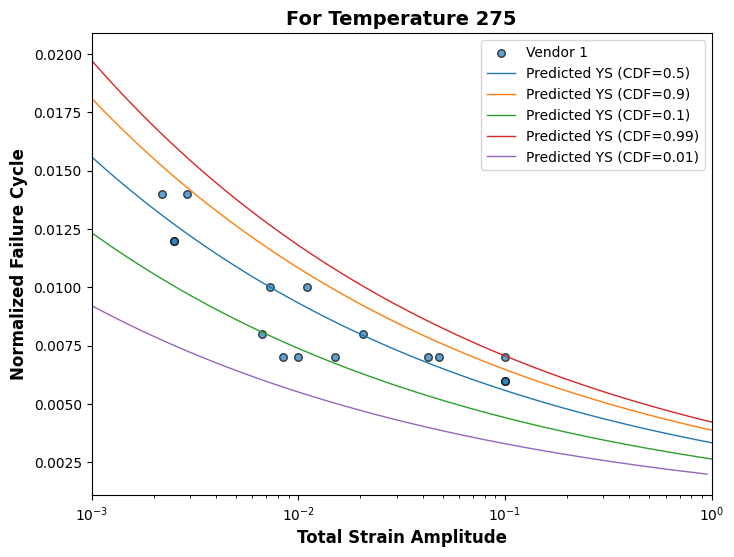

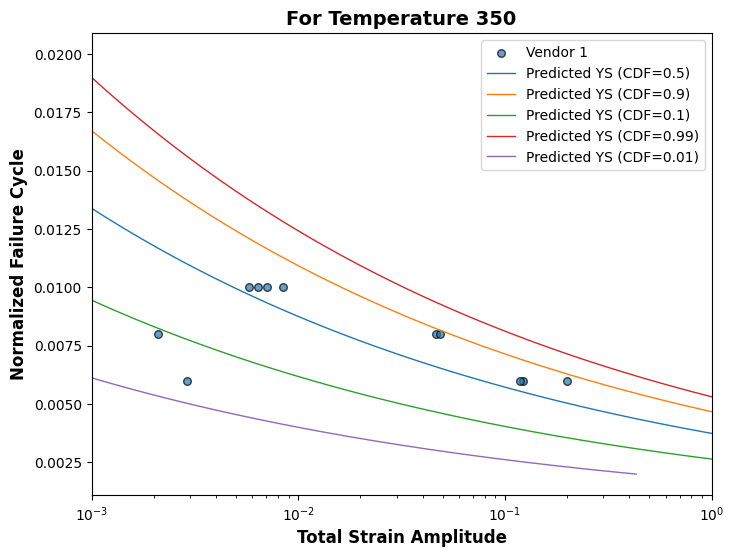

In [177]:
plot_cdf_two_var_diff_temp(wb)

In [117]:
data_lcf['Temperature'].unique()

array([275, 350], dtype=int64)

In [163]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
	"""Log likelihood 

	Args:
		params (list): parameters that are to be determined
		temp (np.ndarray)
		cycles (np.ndarray)

	Returns:
		Gives a negative sum of log likelihood for given data
	"""
	shape = params[0]
	u = params[1]
	w = params[2]
	v = params[3]

	if shape <= 0:
		return np.inf
	scale = np.exp(u + w * temp + v * strain)

	return -np.sum(stats.weibull_min.logpdf(cycles, c=shape, scale=scale))

In [ ]:
init_params = [2.0,-1, np.log(np.mean(data_lcf['Failure cycle'])), -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(1e-6, None),(None, None), (None, None), (None, None)]


params = minimize(log_likelihood, init_params, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
shape, intercept,slope,v  = params
shape, intercept,slope,v

(1.3474091872827747,
 -11.51270694085717,
 -0.050422071464426184,
 -4.68953499692976)

In [166]:
# init_params = [2.0,-1, np.log(np.mean(data_lcf['Failure cycle'])), -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(1e-6, 200),(-20, 20), (-20, 20), (-20, 20)]


params = minimize(log_likelihood, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
shape, intercept,slope,v  = params
shape, intercept,slope,v

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:2584: RuntimeWarning: overflow encountered in power
  return np.log(c) + sc.xlogy(c - 1, x) - pow(x, c)


(1.3474085805405762,
 -11.512897152368788,
 -0.05041923065294537,
 -4.689562558876243)

In [11]:
def wb_predict(cdf,temperature_values, strain_values, params):
    shape, intercept,slope,v = params
    return np.exp(
            (intercept + (slope * 11604.53 / (temperature_values + 273.16)) + v * np.log(strain_values) ) +
            ((1 / shape) * np.log(np.log(1 / (1 - cdf))))
        ) / 1000000

In [143]:
params

array([ 0.99823969, -1.60733247, -0.77866819, -5.42157459])

In [155]:
init_params

[2.0, -1, 10.531048043774492, -3.0]

In [153]:
minimize(wb.log_likelihood, init_params, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2068: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


array([ 2.        , -1.        , 10.53104804, -3.        ])

In [154]:
minimize(log_likelihood, init_params, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))

array([ 0.99823969, -1.60733247, -0.77866819, -5.42157459])

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


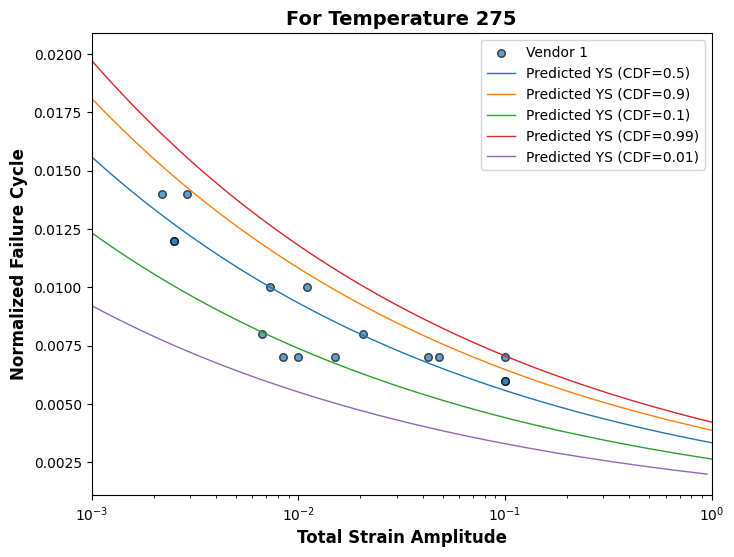

In [168]:
temperature = 275
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(wb.two_var_predict, params, temperature)
# params

## LogNormal:

In [190]:

class LognormalModel(ProbModel):
    def __init__(self,X_values:np.ndarray, Y_values:np.ndarray,X_values2:np.ndarray=np.array([]), power_law:bool=False)->None:
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "LogNormal Model"
        self.tab_name = "LogNormal"
        if power_law:
            self.name = "LogNormal Model With Power Law"
            self.tab_name = "LogNormal (Power)"

        self.two_var = False
        if len(X_values2):
            self.name = "LogNormal Model With Two variables"
            self.two_var = True

            self.bounds = [(-20, 20),(-20, 20),(1e-6, 20), (-20, 20)]
            self.k, self.m, self.sigma, self.l = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))
        else:
            self.power_law = power_law

            self.bounds = [(-20, 20),(-20, 20), (1e-10, 20)]
            self.k, self.m, self.sigma = self.minimize(self.bounds, args=(self.X_values, self.Y_values))


    def log_likelihood(self,params:list, temp:np.ndarray, sigma_values:np.ndarray, strain:np.ndarray=np.array([])):
        k = params[0]
        m = params[1]
        sigma = params[2]
        if sigma <= 0:
            return np.inf  # Avoid invalid sigma
        
        if self.two_var:
            l = params[3]
            mu = k + m * temp + l*strain
        else:
            mu = k + m * temp

        log_likelihood = np.sum(stats.norm.logpdf(np.log(sigma_values), loc=mu, scale=sigma) - np.log(sigma_values))
        return -log_likelihood  

    def predict(self,cdf, temperature_values, strain_values = np.array([])):
        z = np.sqrt(2) * self.sigma * erfinv(2 * cdf - 1)
        if self.power_law:
            return np.exp(self.k + self.m * np.log(temperature_values) + z)

        elif self.two_var:
            return np.exp(self.k +  (self.m * 11604.53) / (temperature_values + 273.16) + self.l * np.log(strain_values) + z) / 1000000
        return np.exp(self.k + (self.m * 11604.53) / (temperature_values + 273.16) + z)
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        k, m, sigma, l = params
        z = np.sqrt(2) * sigma * erfinv(2 * cdf - 1)
        return np.exp(k +  (m * 11604.53) / (temperature_values + 273.16) + l * np.log(strain_values) + z) / 1000000
    
    @staticmethod
    def estimate_params(data):
        log_data = np.log(data)
        mu, sigma = np.mean(log_data), np.std(log_data, ddof=0)
        return mu, sigma
    
    def transform(self,data, temp):
        n = len(data)
        cdf_values = np.array([median_rank(n, i + 1) for i in range(n)])

        # X-axis: ln(data), Y-axis: inverse CDF of normal
        sigma_values = np.log(data)
        pred_sigma_values = stats.lognorm.ppf(cdf_values, s=self.sigma)  # log(Normal quantile)

        # Generate fitted line
        sigma_line = np.linspace(min(data), max(data), 100)
        inverse_temp = 11604.53 / (temp + 273.16)
        median = np.exp(self.k + self.m * inverse_temp)

        if self.power_law:
            median = np.exp(self.k + self.m * np.log(temp))

        pred_sigma_line = stats.lognorm.ppf(stats.lognorm.cdf(sigma_line, s=self.sigma, scale=median), s=self.sigma)
        self.transform_y_label = "Standard Normal Quantile"

        return sigma_values, pred_sigma_values, np.log(sigma_line), pred_sigma_line

In [191]:
lm = LognormalModel(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Ln_Strain'])
lm.k, lm.m, lm.sigma, lm.l

(-12.914385614013005, 0.1432207918428692, 1.200294147596198, -4.06825420730781)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


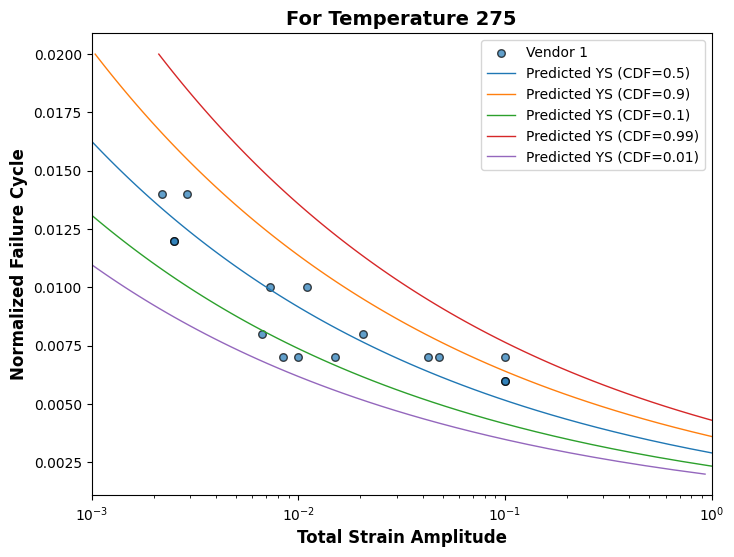

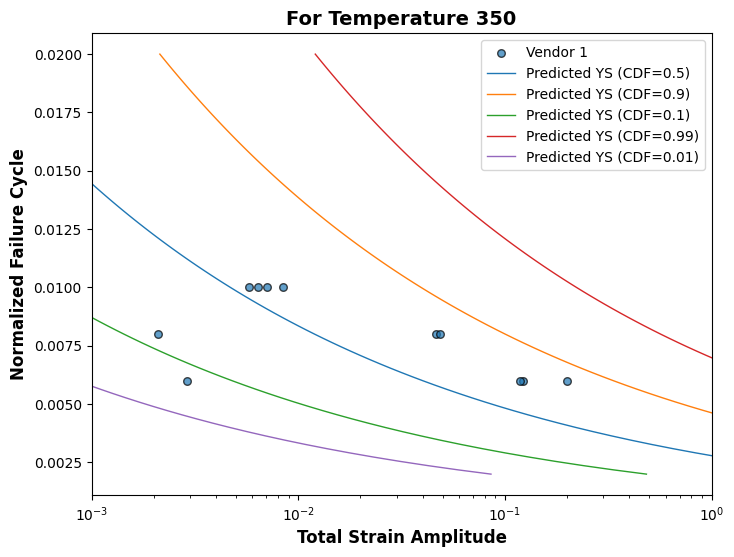

In [192]:
plot_cdf_two_var_diff_temp(lm)

In [193]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
	"""Log likelihood 

	Args:
		params (list): parameters that are to be determined
		temp (np.ndarray)
		cycles (np.ndarray)

	Returns:
		Gives a negative sum of log likelihood for given data
	"""
	sigma = params[0]
	k = params[1]
	m = params[2]
	l = params[3]

	if sigma <= 0:
		return np.inf

	mu = k + m * temp + l*strain
	log_likelihood = np.sum(stats.norm.logpdf(np.log(cycles), loc=mu, scale=sigma) - np.log(cycles))

	return -log_likelihood  

In [194]:
bounds = [(1e-6, 20),(-20, 20),(-20, 20), (-20, 20)]
params = minimize(log_likelihood, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
params

array([  1.20030696, -12.91413263,   0.14319987,  -4.06829044])

In [196]:
def ln_predict(cdf,temperature_values, strain_values, params):
    sigma, k, m, l = params
    z = np.sqrt(2) * sigma * erfinv(2 * cdf - 1)
    return np.exp(k + (m * 11604.53) / (temperature_values + 273.16) + l * np.log(strain_values) + z) / 1000000

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


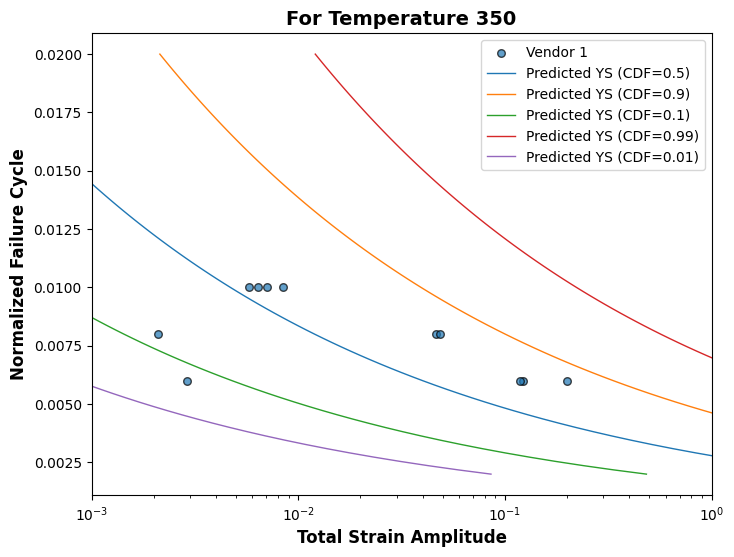

In [199]:
temperature = 350
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(ln_predict, params, temperature)

## Normal Model:

In [ ]:
# See the normal method later, as it's not working perfectly, so see whether to include this or not

In [345]:
class NormalModel(ProbModel):
    def __init__(self, X_values, Y_values, X_values2):
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Normal Model"
        self.tab_name = "Normal"

        self.two_var = False
        if len(X_values2):
            self.name = "Normal Model With Two variables"
            self.two_var = True
            self.bounds = [(1e-6, 100000),(-100000, 100000), (-100000, 100000), (-100000, 100000)]

            self.sigma, self.intercept, self.slope, self.q = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))

        else:
            self.bounds = [(1e-6, 30),(-300, 300), (-20, 20), (-300, 300)]
            self.sigma, self.intercept, self.slope = self.minimize(self.bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self, params,temp, sigma_values, strain:np.ndarray=np.array([])):
        sigma = params[0]
        k = params[1]
        m = params[2]
        
        if sigma <= 0:
            return np.inf  # Avoid invalid sigma
        
        if self.two_var:
            l = params[3]
            mu = k + m * temp + l*strain
        else:
            mu = k + m * temp
        log_likelihood = np.sum(stats.norm.logpdf(sigma_values, loc=mu, scale=sigma))

        return -log_likelihood

    def predict(self,cdf, temperature_values, strain_values:np.ndarray=np.array([])):
        z = np.sqrt(2) * self.sigma * erfinv(2 * cdf - 1)
        if self.two_var:
            return self.intercept + (self.slope * 11604.53) / (temperature_values + 273.16) + self.q * np.log(strain_values) + z
        return self.intercept + (self.slope * 11604.53) / (temperature_values + 273.16) + z
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        sigma, k, m, l = params
        z = np.sqrt(2) * sigma * erfinv(2 * cdf - 1)
        return np.exp(k + (m * 11604.53) / (temperature_values + 273.16) + l * np.log(strain_values) + z) / 1000000

In [346]:
nm = NormalModel(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Strain amplitude'])
nm.sigma, nm.intercept, nm.slope, nm.q

(53505.29328536794, 75633.81406812397, -1893.0362916705826, -17972.83465836832)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\171863683.py:47: RuntimeWarning: overflow encountered in exp
  return np.exp(k + (m * 11604.53) / (temperature_values + 273.16) + l * np.log(strain_values) + z) / 1000000
C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


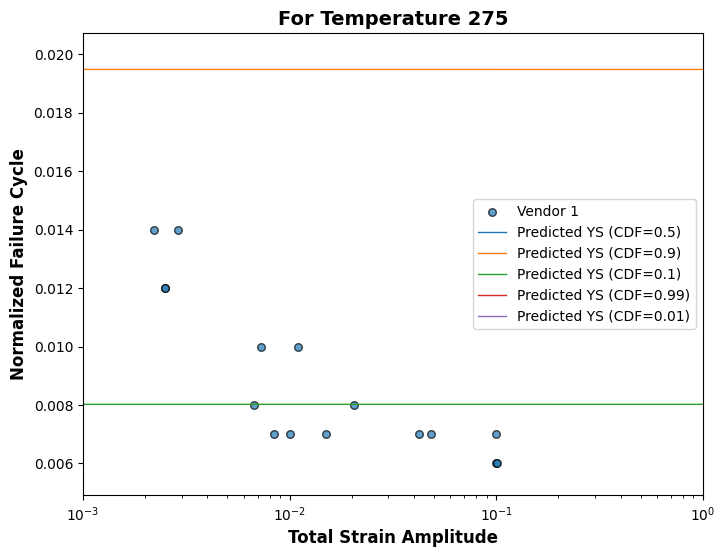

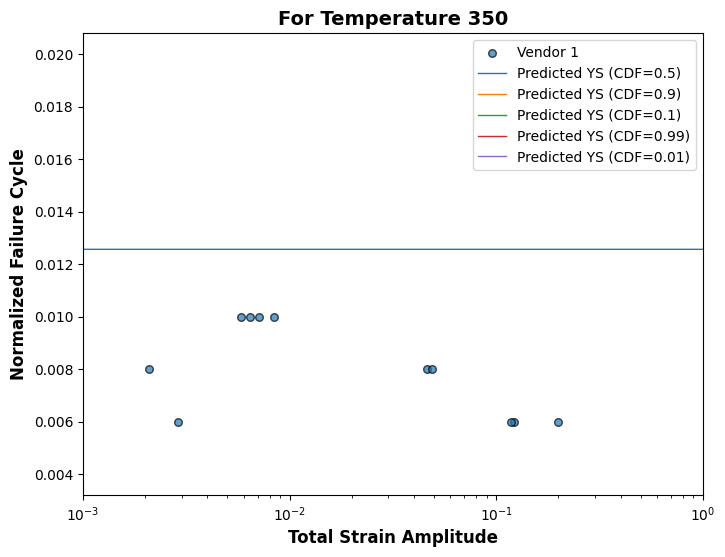

In [347]:
plot_cdf_two_var_diff_temp(nm)

In [ ]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
	"""Log likelihood 

	Args:
		params (list): parameters that are to be determined
		temp (np.ndarray)
		cycles (np.ndarray)

	Returns:
		Gives a negative sum of log likelihood for given data
	"""
	sigma = params[0]
	k = params[1]
	m = params[2]
	l = params[3]

	if sigma <= 0:
		return np.inf

	mu = k + m * temp + l*strain
	log_likelihood = np.sum(stats.norm.logpdf(cycles, loc=mu, scale=sigma))

	return -log_likelihood  

In [76]:
init_params = [2.0,-1.0, np.log(np.mean(data_lcf['Failure cycle'])), -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(1e-6, None),(None, None), (None, None), (None, None)]

params = minimize(log_likelihood, init_params, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
sigma, k, m, l  = params
sigma, k, m, l

(41978.47315483013,
 -16414.301184527918,
 -12973.189427801784,
 -65584.85535164714)

In [344]:
# init_params = [2.0,-1.0, np.log(np.mean(data_lcf['Failure cycle'])), -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(1e-6, 100000),(-100000, 100000), (-100000, 100000), (-100000, 100000)]

params = minimize(log_likelihood, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
sigma, k, m, l  = params
sigma, k, m, l

(41085.324817534296,
 -99272.57705820215,
 -11057.908537592628,
 -74845.04812918368)

In [82]:
def ln_predict(cdf,temperature_values, strain_values, params):
    sigma, k, m, l = params
    z = np.sqrt(2) * sigma * erfinv(2 * cdf - 1)
    return np.exp(k + (m * 11604.53) / (temperature_values + 273.16) + l * np.log(strain_values) + z) / 1000000

In [99]:
data_lcf.keys()

Index(['Temperature', 'Strain amplitude', 'Unnamed: 2', 'Failure cycle',
       'Inverse_Temp', 'Ln_Strain'],
      dtype='object')

In [100]:
nm = NormalModel(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Strain amplitude'])

In [ ]:
# Write the code of how to 

In [102]:
nm.intercept, nm.slope, nm.sigma, nm.q

(1118.3226499135349, 1779.4290297169434, 50273.49329165995, 96.90719243300866)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\2210331323.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(
C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


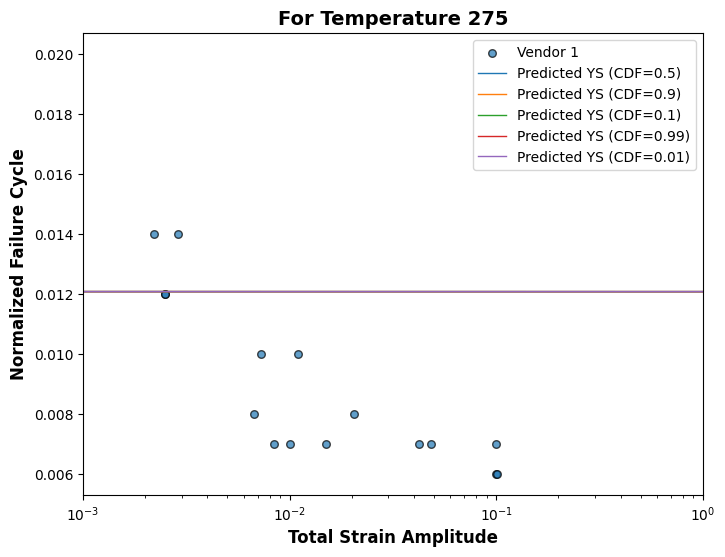

In [87]:
temperature = 275
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, init_params, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(wb_predict, params, temperature)

## Exponential: 

In [223]:
class Exponential(ProbModel):
    def __init__(self,X_values, Y_values, X_values2:np.ndarray=np.array([])):
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Exponential Model"
        self.tab_name = "Exponential"

        self.two_var = False
        if len(X_values2):
            self.bounds = [(-20, 20), (-20, 20), (-20, 20)]
            self.name = "Exponential Model with two variables"
            self.two_var = True 

            self.intercept, self.slope, self.v = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))
        else:
            bounds = [(-20, 20), (-20, 20)]
            self.minimize(bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self,params, temp, sigma_values, strain_values = np.array([])):
        """Exponential Log likelihood"""
        u = params[0]
        w = params[1]

        if self.two_var:
            v = params[2]
            scale = np.exp(u + w * temp + v * strain_values)
        else:
            scale = np.exp(u + w * temp)
                
        return -np.sum(stats.expon.logpdf(sigma_values, scale=scale))

    def predict(self,cdf, temperature_values):
        inv_temp_range = 11604.53 / (temperature_values + 273.16)
        lambda_vals = np.exp(self.intercept + self.slope * inv_temp_range)
        return -lambda_vals * np.log(1 - cdf)
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        u,w,v  = params
        inv_temp_range = 11604.53 / (temperature_values + 273.16)
        lambda_vals = np.exp(u + w * inv_temp_range + v * np.log(strain_values))
        return -lambda_vals * np.log(1 - cdf) / 1000000

In [221]:
ex = Exponential(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Ln_Strain'])
ex.intercept, ex.slope, ex.v

(-11.49224974240382, -0.039161063882057645, -4.623220690254254)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


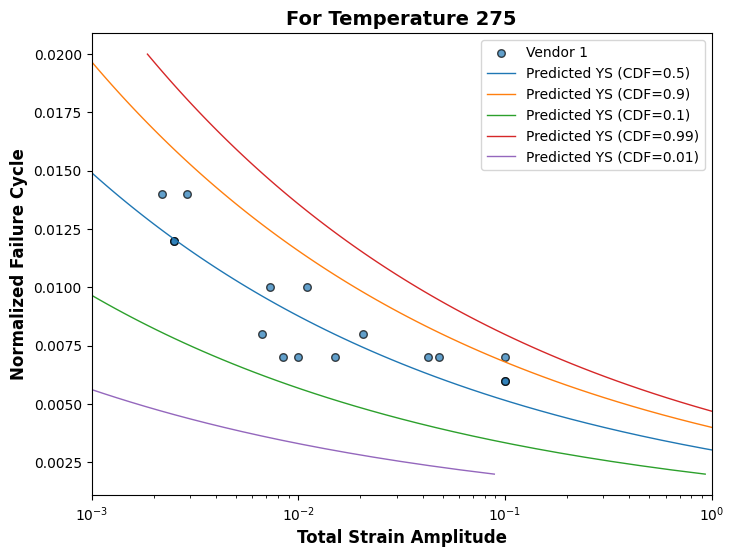

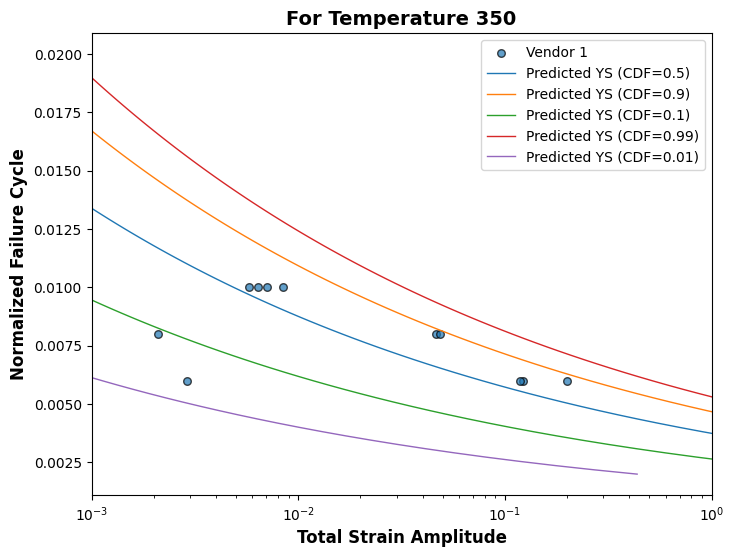

In [222]:
plot_cdf_two_var_diff_temp(ex)

In [217]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
    """Log likelihood 

    Args:
        params (list): parameters that are to be determined
        temp (np.ndarray)
        cycles (np.ndarray)

    Returns:
        Gives a negative sum of log likelihood for given data
    """
    u = params[0]
    w = params[1]
    v = params[2]

    scale = np.exp(u + w * temp + v * strain)

    return -np.sum(stats.expon.logpdf(cycles, scale=scale))

In [202]:
init_params = [np.log(np.mean(data_lcf['Failure cycle'])),0.0, -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(-20, 20), (-20, 20), (-20, 20)]

params = minimize(log_likelihood, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
u,w,v  = params
u,w,v

(-11.915037967215012, -0.02879244313035177, -4.667810100654989)

In [203]:
def ln_predict(cdf,temperature_values, strain_values, params):
    u,w,v  = params
    inv_temp_range = 11604.53 / (temperature_values + 273.16)
    lambda_vals = np.exp(u + w * inv_temp_range + v * np.log(strain_values))
    return -lambda_vals * np.log(1 - cdf) / 1000000

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


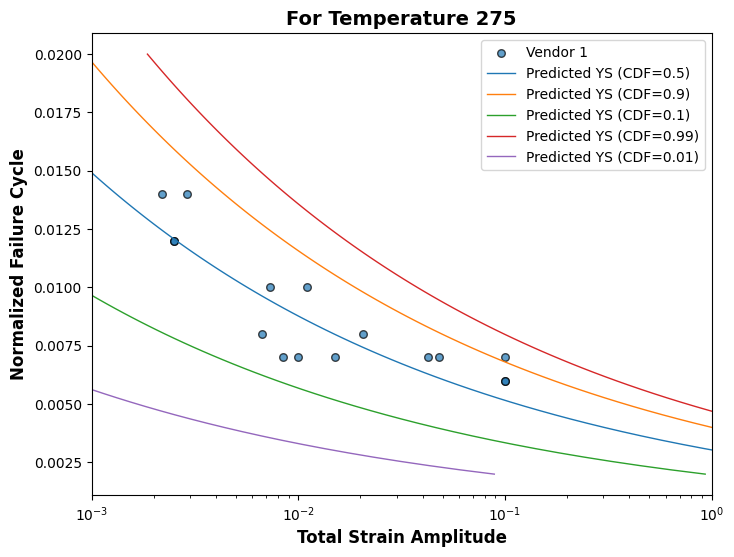

In [204]:
temperature = 275
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(ln_predict, params, temperature)

## Gumbell:

In [237]:
class Gumbell(ProbModel):   
    def __init__(self,X_values, Y_values,X_values2:np.ndarray=np.array([])):
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Gumbell Model"
        self.tab_name = "Gumbell"

        self.two_var = False
        if len(X_values2):
            # self.init_params = [2.0,-1, np.log(np.mean(self.Y_values)), -3.0]
            self.bounds = [(-100000, 100000),(-100000, 100000),(1e-6, 100000), (-100000, 100000)]
            self.name = "Gumbell Model With Two variables"
            self.two_var = True

            self.intercept, self.slope,self.scale, self.v = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))
        else:
            # init_params = [2.0, np.log(np.mean(self.Y_values)), 0.0]
            bounds = [(-20, 20), (-20, 20), (1e-6, 20)]

            self.intercept, self.slope,self.scale = self.minimize( bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self,params, temp, sigma_values, strain_values=np.array([])):
        """Gumbell Log likelihood"""
        u = params[0]           # Intercept
        w = params[1]        # Slope
        scale = params[2]        # Scale

        if scale <= 0:
            return np.inf
        
        if self.two_var:
            v = params[3]
            loc = u + w * temp + v * strain_values
        else:
            loc = u + w * temp
        z = (sigma_values - loc) / scale
        z = np.clip(z, -700, 700)  # -exp(-z) overflows around -745
        logpdf = -z - np.exp(-z) - np.log(scale)
        return -np.sum(logpdf)

    def predict(self,cdf, temperature_values,strain_values=np.array([])):
        inv_temp = 11604.53 / (temperature_values + 273.16)
        if self.two_var:
            return (self.intercept + self.slope * inv_temp + self.v*np.log(strain_values) - self.scale * np.log(-np.log(cdf))) / 1000000
        
        return self.intercept + self.slope * inv_temp - self.scale * np.log(-np.log(cdf))
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        u,w,scale,v = params
        inv_temp = 11604.53 / (temperature_values + 273.16)
        return (u + w * inv_temp + v*np.log(strain_values) - scale * np.log(-np.log(cdf)))/1000000

In [238]:
gb = Gumbell(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Ln_Strain'])
gb.intercept, gb.slope,gb.scale, gb.v

(-100000.0, -1973.0961555580018, 26872.99220503534, -33120.2896869243)

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


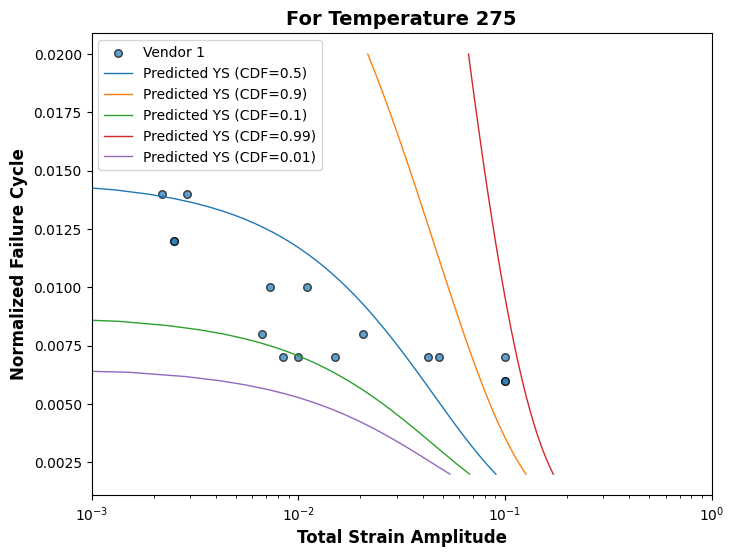

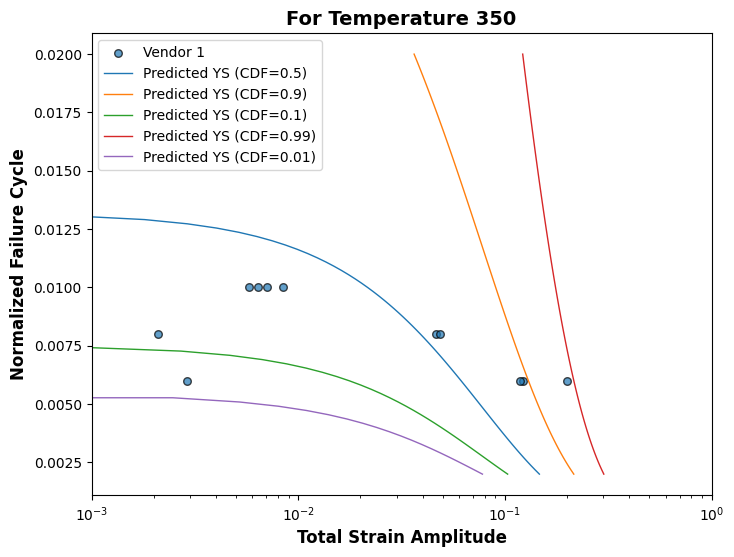

In [239]:
plot_cdf_two_var_diff_temp(gb)

In [224]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
    """Gumbell Log likelihood"""
    u = params[0]           # Intercept
    w = params[1]        # Slope
    scale = params[2]        # Scale
    v = params[3]

    if scale <= 0:
        return np.inf
    
    loc = u + w * temp + v * strain
    z = (cycles - loc) / scale
    z = np.clip(z, -700, 700)  # -exp(-z) overflows around -745
    logpdf = -z - np.exp(-z) - np.log(scale)
    return -np.sum(logpdf)

In [229]:
init_params = [np.mean(data_lcf['Failure cycle']),0.0, np.std(data_lcf['Failure cycle']), -3.0]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(-100000, 100000),(-100000, 100000), (1e-6, 100000), (-100000, 100000)]

params = minimize(log_likelihood, bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
u,w,scale,v  = params
u,w,scale,v

(-96913.6492411525,
 -1699.9342769970444,
 26838.17825749779,
 -31294.336520177512)

In [231]:
def gb_predict(cdf,temperature_values, strain_values, params):
    u,w,scale,v = params
    inv_temp = 11604.53 / (temperature_values + 273.16)
    return (u + w * inv_temp + v*np.log(strain_values) - scale * np.log(-np.log(cdf)))/1000000

C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


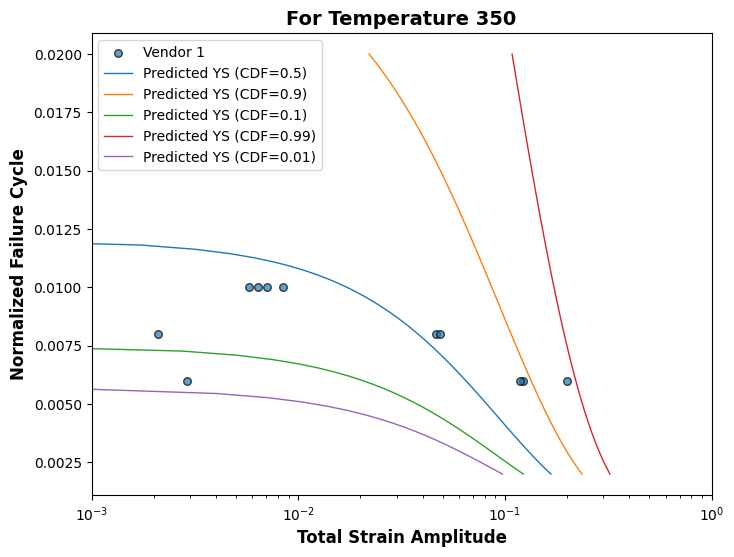

In [234]:
temperature = 350
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(gb_predict, params, temperature)

## Gamma: 

In [335]:
class Gamma(ProbModel):
    def __init__(self,X_values, Y_values,X_values2:np.ndarray=np.array([])):
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Gamma Model"
        self.tab_name = "Gamma"

        self.two_var = False
        if len(X_values2):
            self.two_var = True
            self.bounds = [(1e-6, 20), (-20, 20),(-20, 20), (-20, 20)]
            self.shape,self.intercept, self.slope, self.v = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))

        else:
            self.bounds = [(1e-6, 1000), (-20, 20),(-20, 20)]
            self.shape,self.intercept, self.slope= self.minimize(self.bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self,params, temp, sigma_values, strain_values:np.ndarray=np.array([])):
        """Exponential Log likelihood"""
        u = params[1]
        w = params[2]
        shape = params[0]
        if self.two_var:
            v = params[3]
            scale = np.exp(u + w * temp + v * strain_values)
        else:
            scale = np.exp(u + w * temp)
        
        return -np.sum(stats.gamma.logpdf(sigma_values, a=shape, scale=scale))

    def predict(self,cdf, temperature_values, strain_values:np.ndarray=np.array([])):
        inv_temp_range = 11604.53 / (temperature_values + 273.16)

        if self.two_var:
            scale_range = np.exp(self.intercept + self.slope * inv_temp_range + self.v * np.log(strain_values))
            return stats.gamma.ppf(cdf, a=shape, scale=scale_range) / 1000000

        scale_range = np.exp(self.intercept + self.slope * inv_temp_range)
        return stats.gamma.ppf(cdf, a=self.shape, scale=scale_range)
    
    def two_var_predict(self, cdf:float, temperature_values:np.ndarray, strain_values:np.ndarray, params:np.ndarray) -> np.ndarray:
        shape,u,w,v  = params
        inv_temp_range = 11604.53 / (temperature_values + 273.16)
        scale_range = np.exp(u + w * inv_temp_range + v * np.log(strain_values))
        return stats.gamma.ppf(cdf, a=shape, scale=scale_range) / 1000000

In [336]:
gm = Gamma(data_lcf['Inverse_Temp'], data_lcf['Failure cycle'], data_lcf['Ln_Strain'])
gm.shape,gm.intercept, gm.slope, gm.v

(1.3178874761166697,
 -11.76851671866052,
 -0.039158799215001226,
 -4.623257404023777)

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


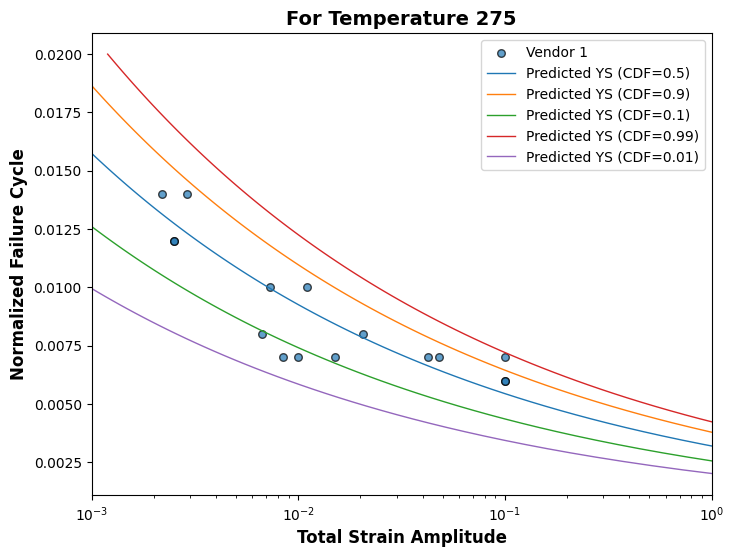

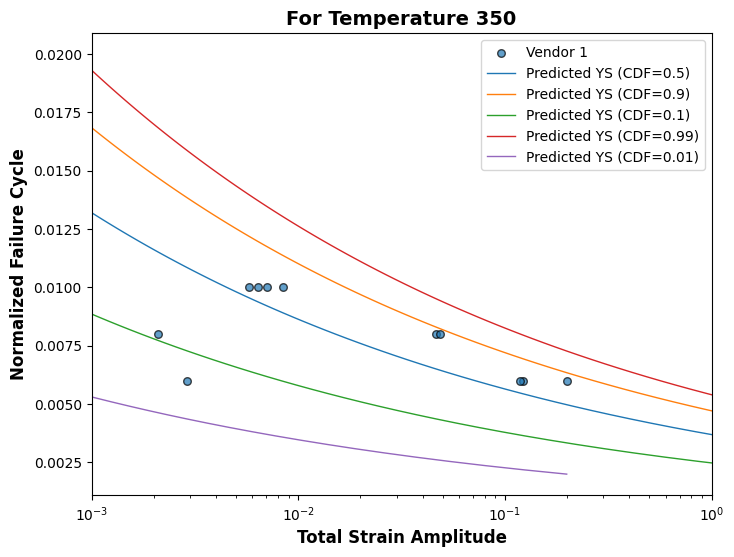

In [337]:
plot_cdf_two_var_diff_temp(gm)

In [315]:
def log_likelihood(params:list, temp:np.ndarray, strain:np.ndarray, cycles:np.ndarray):
    """Log likelihood 

    Args:
        params (list): parameters that are to be determined
        temp (np.ndarray)
        cycles (np.ndarray)

    Returns:
        Gives a negative sum of log likelihood for given data
    """
    u = params[1]
    w = params[2]
    shape = params[0]
    v = params[3]

    scale = np.exp(u + w * temp + v * strain)
    
    return -np.sum(stats.gamma.logpdf(cycles, a=shape, scale=scale))

In [318]:
init_params = [0.1,0.1, -3.0, 0.1]
# init_params = [1.66372,-13.4945,-0.043647, -5.08767]
bounds = [(1e-6, 20), (-20, 20), (-20, 20), (-20, 20)]

params = minimize(log_likelihood,  bounds, (data_lcf['Inverse_Temp'], data_lcf['Ln_Strain'], data_lcf['Failure cycle']))
u,w,v,shape  = params
u,w,v, shape

(1.3179113308983958,
 -11.768188275295428,
 -0.03916129269340723,
 -4.623196719081144)

In [255]:
def ln_predict(cdf,temperature_values, strain_values, params):
    u,w,v, shape  = params
    inv_temp_range = 11604.53 / (temperature_values + 273.16)
    scale_range = np.exp(u + w * inv_temp_range + v * np.log(strain_values))
    return stats.gamma.ppf(cdf, a=shape, scale=scale_range) / 1000000

In [277]:
params

array([-18.31179783,   0.30108582,  -4.33940975,   2.62599214])

In [283]:
def ln_predict(cdf,temperature_values, strain_values, params):
    shape,u,w,v  = params
    inv_temp_range = 11604.53 / (temperature_values + 273.16)
    scale_range = np.exp(u + w * inv_temp_range + v * np.log(strain_values))
    return stats.gamma.ppf(cdf, a=shape, scale=scale_range) / 1000000

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\mohit\AppData\Local\Temp\ipykernel_16344\4099816030.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


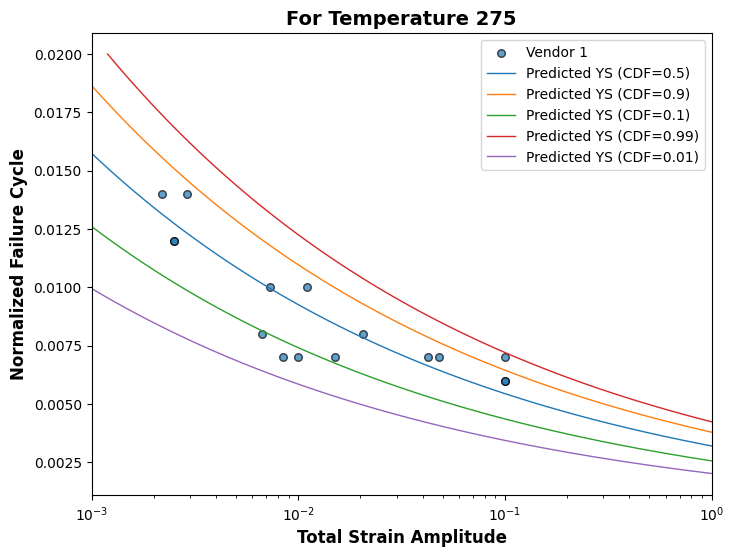

In [282]:
bounds = [(-20, 20), (-20, 20), (-20, 20), (1e-6, 20)]
temperature = 275
data = data_lcf[data_lcf['Temperature']==temperature]
params = minimize(log_likelihood, bounds, (data['Inverse_Temp'], data['Ln_Strain'], data['Failure cycle']))
plot_different_cdf_two_var(ln_predict, params, temperature)